<a href="https://colab.research.google.com/github/takiyama0617/colaboratory/blob/master/sample_chainer%2BMNIST_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import chainer
import chainer.links as L
import chainer.functions as F

In [0]:
train_data, test_data = chainer.datasets.get_mnist(withlabel=True, ndim=1)

### ニューラルネットワークの定義
* Chainerフレームワークが提供しているchainer.Chainクラスを継承する形で定義する
* これは、Chainerフレームワークを使って、ニューラルネットワークを定義するときの一般的なやり方

In [0]:
class MLP(chainer.Chain) :
  # number_hidden_unitsは、中間層（隠れ層）のユニット数
  # number_out_unitsは、出力層のユニット数　
  def __init__(self, number_hidden_units=1000, number_out_units=10) :
    super(MLP, self).__init__()
    with self.init_scope() :
      self.layer1 = L.Linear(None, number_hidden_units)
      self.layer2 = L.Linear(number_hidden_units, number_hidden_units)
      self.layer3 = L.Linear(number_hidden_units, number_out_units)
  
  def __call__(self, input_data) :
    result1 = F.relu(self.layer1(input_data))
    result2 = F.relu(self.layer2(result1))
    return self.layer3(result2)

In [0]:
model = MLP()

In [38]:
print('入力層のバイアスパラメータ配列の形は', model.layer1.b.shape)
print('初期化直後のその値は、', model.layer1.b.data)

入力層のバイアスパラメータ配列の形は (1000,)
初期化直後のその値は、 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.

In [39]:
print('学習前の入力層の重み配列', model.layer1.W.array)

学習前の入力層の重み配列 None


In [0]:
from chainer import iterators

BATCH_SIZE = 100
train_iterator = iterators.SerialIterator(train_data, BATCH_SIZE)
test_iterator = iterators.SerialIterator(test_data, BATCH_SIZE, repeat=False, shuffle=False)

### Optimizerの設定
* 今回は、一番シンプルな確率的勾配降下法のoptimizers.SGDを使用
* lrは、learn rateの略で学習率のこと
 * このパラメータを調整すれば、学習の結果に影響を与える

In [41]:
from chainer import optimizers

optimizer = optimizers.SGD(lr=0.01)
optimizer.setup(model)

In [0]:
import numpy as np
from chainer.dataset import concat_examples
import matplotlib.pyplot as plt

# 学習の回数
MAX_EPOCH = 20

In [0]:
def testEpoch(train_iterator, loss) :
  print('学習回数：{:02d} --> 学習誤差：{:.02f}' .format(train_iterator.epoch, float(loss.data)), end='')

  # 検証用誤差と精度
  test_losses = []
  test_accuracies = []

  while True :
    test_dataset = test_iterator.next()
    test_data, test_teacher_labels = concat_examples(test_dataset)

    # 検証用データをモデルへ
    prediction_test = model(test_data)

    # 検証データに対して得られた予測値と教師データを比較して、ロスの計算をする
    loss_test = F.softmax_cross_entropy(prediction_test, test_teacher_labels)
    test_losses.append(loss_test.data)

    # 精度を計算
    accuracy = F.accuracy(prediction_test, test_teacher_labels)
    test_accuracies.append(accuracy.data)

    if test_iterator.is_new_epoch:
      test_iterator.reset()
      break

    print('検証誤差：{:.04f} 検証精度：{:.02f}' .format(np.mean(test_losses), np.mean(test_accuracies)))


In [44]:
while train_iterator.epoch < MAX_EPOCH:
  # 学習データセットを反復子から取り出す
  train_dataset = train_iterator.next()

  # 学習データを学習データと教師データにアンパック
  train_data, teacher_labels = concat_examples(train_dataset)

  # 予測値の計算
  prediction_train = model(train_data)
  
  # 予測値と教師データを比較し、学習誤差を計算
  loss = F.softmax_cross_entropy(prediction_train, teacher_labels)
  
  # ニューラルネットワークの勾配の計算
  model.cleargrads()
  # 誤差を逆伝播
  loss.backward()
  # 誤差を反映して、パラメータ更新
  optimizer.update()
  # 一回学習が終わったら、検証データに対する予測精度を測る
  if train_iterator.is_new_epoch:
    testEpoch(train_iterator, loss)


学習回数：01 --> 学習誤差：0.56検証誤差：0.4888 検証精度：0.87
検証誤差：0.4799 検証精度：0.90
検証誤差：0.4958 検証精度：0.89
検証誤差：0.5157 検証精度：0.88
検証誤差：0.5321 検証精度：0.87
検証誤差：0.5534 検証精度：0.86
検証誤差：0.5599 検証精度：0.85
検証誤差：0.5469 検証精度：0.86
検証誤差：0.5338 検証精度：0.86
検証誤差：0.5412 検証精度：0.86
検証誤差：0.5409 検証精度：0.86
検証誤差：0.5518 検証精度：0.86
検証誤差：0.5775 検証精度：0.85
検証誤差：0.5765 検証精度：0.85
検証誤差：0.5769 検証精度：0.85
検証誤差：0.5790 検証精度：0.85
検証誤差：0.5793 検証精度：0.85
検証誤差：0.5879 検証精度：0.85
検証誤差：0.5843 検証精度：0.85
検証誤差：0.5839 検証精度：0.85
検証誤差：0.5895 検証精度：0.85
検証誤差：0.5988 検証精度：0.85
検証誤差：0.5995 検証精度：0.85
検証誤差：0.5978 検証精度：0.85
検証誤差：0.5940 検証精度：0.85
検証誤差：0.5938 検証精度：0.85
検証誤差：0.5939 検証精度：0.85
検証誤差：0.5905 検証精度：0.85
検証誤差：0.5852 検証精度：0.85
検証誤差：0.5854 検証精度：0.85
検証誤差：0.5806 検証精度：0.85
検証誤差：0.5808 検証精度：0.85
検証誤差：0.5787 検証精度：0.85
検証誤差：0.5765 検証精度：0.85
検証誤差：0.5740 検証精度：0.85
検証誤差：0.5763 検証精度：0.85
検証誤差：0.5727 検証精度：0.85
検証誤差：0.5782 検証精度：0.85
検証誤差：0.5833 検証精度：0.85
検証誤差：0.5840 検証精度：0.85
検証誤差：0.5831 検証精度：0.85
検証誤差：0.5821 検証精度：0.85
検証誤差：0.5844 検証精度：0.85
検証誤差：0.5840 検証精度：0.85
検証誤差：0.5852

In [45]:
print('入力層のバイアスパラメータ配列の形状は', model.layer1.b.shape)
print('学習後の入力層の値は、', model.layer1.b.data)
print('学習後の入力層の重み配列', model.layer1.W.array)
print('学習後の入力層の重み配列の形状は', model.layer1.W.array.shape)

入力層のバイアスパラメータ配列の形状は (1000,)
学習後の入力層の値は、 [ 8.12849868e-03  9.38278250e-03  1.25567932e-02  1.07194856e-02
  1.01914210e-02  4.08484018e-04  1.25459982e-02 -5.49947610e-03
 -3.34241474e-03  3.17491964e-03  9.32424143e-03  5.54700242e-03
  1.41488500e-02 -3.58908554e-03  5.14816912e-03  1.95610411e-02
 -6.17707660e-03  1.68244971e-03  9.28103924e-04  6.31661667e-03
  5.09832986e-03  8.00873619e-03  6.09810464e-03  8.54047760e-03
  5.54733956e-03 -8.13151523e-03  3.82251036e-03  1.27707655e-02
  6.70507643e-03  2.47849966e-03  9.35598370e-03  9.41461883e-03
  1.03079937e-02  2.69871118e-04  1.65872404e-03  7.57118175e-03
  5.68170380e-03  6.57626381e-03 -9.19365208e-04  6.17492711e-03
  8.60416621e-04  8.55282851e-05  2.01942492e-02  7.69140804e-03
 -1.92386983e-03 -1.23307202e-03 -3.65297520e-03  5.67810424e-03
  2.24944233e-04  4.58531640e-03  2.83849775e-03  1.48726804e-02
  6.49737567e-03  5.93831949e-03  1.32495603e-02  3.36718094e-03
  2.46457197e-02  1.11373728e-02  5.48280589e-03  

### 学習済みモデルを保存する

In [47]:
from chainer import serializers

serializers.save_npz('chainer-mnist.model', model)

# 保存されているか確認
%ls -al

total 6536
drwxr-xr-x 1 root root    4096 Feb 25 13:24 ./
drwxr-xr-x 1 root root    4096 Feb 25 12:20 ../
-rw-r--r-- 1 root root 6674790 Feb 25 13:24 chainer-mnist.model
drwxr-xr-x 1 root root    4096 Feb 19 17:12 .config/
drwxr-xr-x 1 root root    4096 Feb  5 18:37 sample_data/


In [0]:
from google.colab import files
files.download('chainer-mnist.model')

### 学習済みモデルを使う

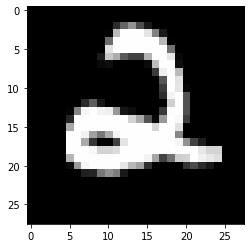

predict_label :  2


In [50]:
model = MLP()

# 学習済みモデルのロード
serializers.load_npz('chainer-mnist.model', model)

train_data, test_data = chainer.datasets.get_mnist(withlabel=True, ndim=1)
# 検証データの１つを使ってみる
data_location = 6423
predict_data, predict_label = test_data[data_location]
plt.imshow(predict_data.reshape(28, 28), cmap='gray')
plt.show()
print('predict_label : ', predict_label)

In [51]:
# 分類したいデータをモデルに渡す
predict_data = predict_data[None, ...]
predict = model(predict_data)
result = predict.array
print(result)
probable_label = result.argmax(axis=1)
print('1番可能性の高いのは：', probable_label[0])

[[ 1.6250339  -6.142984   14.86213     1.5099919   0.51885664 -4.465475
   5.0985856  -8.667216   -0.4425695  -6.0740356 ]]
1番可能性の高いのは： 2
